In [18]:
# Install Kaggle
!pip install -q kaggle

# Upload kaggle.json
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

# Configure Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d patrickfleith/nasa-anomaly-detection-dataset-smap-msl

# Unzip without overwrite prompt
!mkdir -p data_temp
!unzip -oq nasa-anomaly-detection-dataset-smap-msl.zip -d data_temp

# Organize train and test folders
import os
import shutil

# Remove existing data directories to prevent 'Destination path already exists' error on re-run
if os.path.exists('data/train'):
    shutil.rmtree('data/train')
if os.path.exists('data/test'):
    shutil.rmtree('data/test')

!mkdir -p data/train data/test

for root, dirs, files_list in os.walk('/content/data_temp'):
    if 'train' in dirs:
        for f in os.listdir(os.path.join(root, 'train')):
            shutil.move(os.path.join(root, 'train', f), 'data/train/')
    if 'test' in dirs:
        for f in os.listdir(os.path.join(root, 'test')):
            shutil.move(os.path.join(root, 'test', f), 'data/test/')

print("Data setup complete.")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle (5).json
Dataset URL: https://www.kaggle.com/datasets/patrickfleith/nasa-anomaly-detection-dataset-smap-msl
License(s): copyright-authors
nasa-anomaly-detection-dataset-smap-msl.zip: Skipping, found more recently modified local copy (use --force to force download)
Data setup complete.


In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load telemetry channel (Power channel P-1)
train_data = np.load('data/train/P-1.npy')
test_data  = np.load('data/test/P-1.npy')

# Normalization
normalizer = MinMaxScaler(feature_range=(0, 1))

train_norm = normalizer.fit_transform(train_data)
test_norm  = normalizer.transform(test_data)

# Sliding Window Generator
def build_windows(series, seq_len=50):
    sequences = []
    total_length = len(series)

    for start_idx in range(total_length - seq_len):
        end_idx = start_idx + seq_len
        sequences.append(series[start_idx:end_idx])

    return np.asarray(sequences)

# Generate sequences
WINDOW_LENGTH = 50

X_train = build_windows(train_norm, WINDOW_LENGTH)
X_test  = build_windows(test_norm, WINDOW_LENGTH)

print("Input Data Shape:", X_train.shape)


Input Data Shape: (2822, 50, 25)


In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input

K.clear_session()

SEQ_LENGTH = 50
FEATURE_COUNT = 25

autoencoder = Sequential()

autoencoder.add(Input(shape=(SEQ_LENGTH, FEATURE_COUNT)))
autoencoder.add(LSTM(64, activation='relu'))
autoencoder.add(RepeatVector(SEQ_LENGTH))
autoencoder.add(LSTM(64, activation='relu', return_sequences=True))
autoencoder.add(TimeDistributed(Dense(FEATURE_COUNT)))

autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.summary()

training_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 25)         │         1,625 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,689 (225.35 KB)

 Trainable params: 57,689 (225.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - loss: 0.0322 - val_loss: 0.0314
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0263 - val_loss: 0.0308
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0261 - val_loss: 0.0307
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0263 - val_loss: 0.0308
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0256 - val_loss: 0.0308
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0254 - val_loss: 0.0307
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0260 - val_loss: 0.0306
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0262 - val_loss: 0.0307
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0260 - val_loss: 0.0307
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0260 - val_loss: 0.0306
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0260 - val_loss: 0.0306
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0

89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step
Reconstruction Error Threshold: 0.06815410304836504


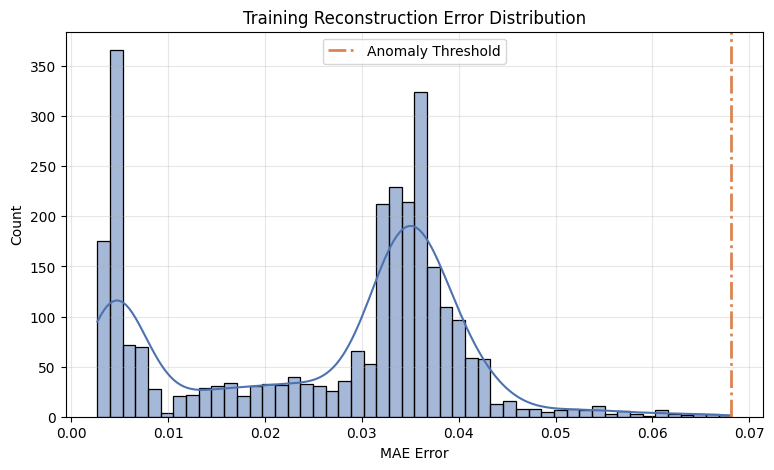

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reconstruct training data
reconstructed_train = autoencoder.predict(X_train)

# Compute MAE per window
train_errors = np.mean(
    np.abs(reconstructed_train - X_train),
    axis=(1, 2)
)

# Threshold from training data
error_limit = train_errors.max()
print("Reconstruction Error Threshold:", error_limit)

plt.figure(figsize=(9, 5))

sns.histplot(
    train_errors,
    bins=50,
    kde=True,
    color="#4C72B0",
    edgecolor="black"
)

plt.axvline(
    error_limit,
    color="#DD8452",
    linestyle="-.",
    linewidth=2,
    label="Anomaly Threshold"
)

plt.title("Training Reconstruction Error Distribution")
plt.xlabel("MAE Error")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [22]:
# ---- Generate Sliding Windows for Test Set ----
X_eval = build_windows(test_norm, WINDOW_LENGTH)

# ---- Reconstruct Test Sequences ----
reconstructed_test = autoencoder.predict(X_eval)

# ---- Compute Reconstruction Error (MAE per window) ----
test_errors = np.mean(
    np.abs(reconstructed_test - X_eval),
    axis=(1, 2)
)

# ---- Flag Windows Exceeding Learned Boundary ----
anomaly_flags = test_errors > error_limit

print("Total Anomalous Windows Detected:", anomaly_flags.sum())

265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Total Anomalous Windows Detected: 9


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Threshold: 0.06948148674375794
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Anomalous windows: 7


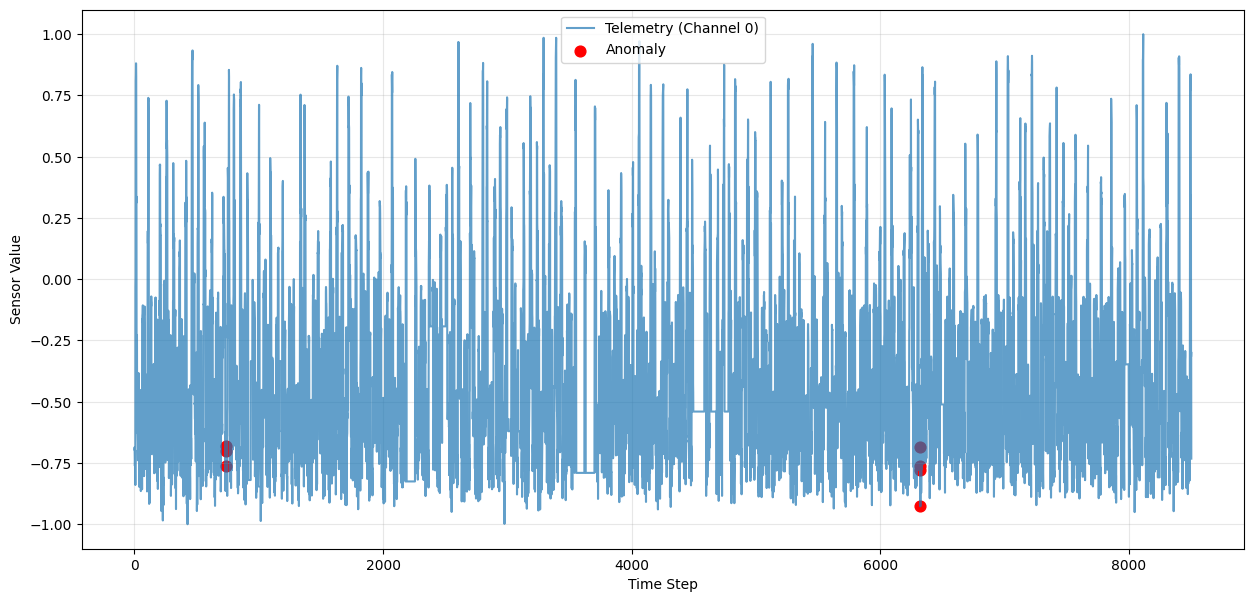

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Training reconstruction error
train_recon = autoencoder.predict(X_train)
train_errors = np.mean(np.abs(train_recon - X_train), axis=(1, 2))

# Threshold (mean + 3*std)
error_limit = train_errors.mean() + 3 * train_errors.std()
print("Threshold:", error_limit)

# Test reconstruction error
test_recon = autoencoder.predict(X_test)
test_errors = np.mean(np.abs(test_recon - X_test), axis=(1, 2))

# Window-level anomaly detection
window_flags = test_errors > error_limit
print("Anomalous windows:", window_flags.sum())

# Map window index to window center
window_indices = np.where(window_flags)[0]
center_points = window_indices + (WINDOW_LENGTH // 2)

# Plot
plt.figure(figsize=(15, 7))
plt.plot(test_data[:, 0], alpha=0.7, label="Telemetry (Channel 0)")
plt.scatter(center_points,
            test_data[center_points, 0],
            color="red",
            s=60,
            label="Anomaly")

plt.xlabel("Time Step")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()